# Project Overview

Brief description of the brain tumor image classification project.

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/christian/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


# Data Loading

Code to load image dataset for brain tumor classification.

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Replace 'path' with your actual dataset path variable if different
train_dir = os.path.join(path, "Training")
glioma_dir = os.path.join(train_dir, "glioma")

# List all image files in the glioma directory
image_files = os.listdir(glioma_dir)
print("Number of images in glioma:", len(image_files))
print("First image file name:", image_files[0])

Number of images in glioma: 1321
First image file name: Tr-gl_0231.jpg


# Data preprocessing

Processed image array shape: (1321, 128, 128)
Data type and range: float64 0.013671875 1.0


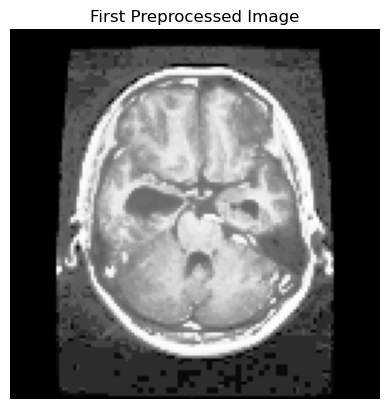

In [10]:
from skimage import exposure

images = []
for filename in image_files:
    img_path = os.path.join(glioma_dir, filename)
    with Image.open(img_path) as img:
        img = img.convert('L')  # Grayscale
        img = img.resize(target_size)
        img_arr = np.array(img) / 255.0
        # Contrast enhancement using histogram equalization
        img_eq = exposure.equalize_hist(img_arr)  # or use equalize_adapthist for CLAHE
        images.append(img_eq)

images = np.array(images)

# Display the first image in the dataset
plt.imshow(images[0], cmap='gray')
plt.axis('off')  # Hide the axis for clarity
plt.title('First Preprocessed Image')
plt.show()

# Exploratory Data Analysis

This section is dedicated to Exploratory Data Analysis (EDA) of the brain tumor classification dataset. It aims to provide insights into the dataset's structure, class distribution, and image properties.


# Model Building

Define the architecture of the classification model (e.g., CNN).

# Model Training

Train the model using the training dataset.

# Model Evaluation

Evaluate the model performance on the validation/test dataset.

# Predictions

Make predictions on new or unseen images.

# Conclusions and Next Steps

Summarize findings and suggest future improvements.